In [1]:
!pip install --upgrade torch torchvision
!pip install -U -q PyDrive

!rm ./checkpoint/ckpt.t7

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (0.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)
Requirement not upgraded as not directly required: numpy in /usr/local/lib/python3.6/dist-packages (from torchvision) (1.14.3)
Requirement not upgraded as not directly required: six in /usr/local/lib/python3.6/dist-packages (from torchvision) (1.11.0)
Requirement not upgraded as not directly required: pillow>=4.1.1 in /usr/local/lib/python3.6/dist-packages (from torchvision) (5.1.0)


In [2]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

print(torch.__version__)

0.4.0


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

is_training = True

batch_size = 128
learning_rate = 0.0001

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

best_loss = 100
best_acc = 0

start_epoch = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'


if not os.path.isdir('./checkpoint'):
    os.mkdir('./checkpoint')
local_download_path = os.path.expanduser('./checkpoint')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'1p7VdRVvtapuSMhavuij8L4J5-0pcAxFX' in parents and trashed = false"}).GetList()

for f in file_list:
    # 3. Create & download by id.
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(local_download_path, f['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='/content/pytorch/data/cifar10/',
                                 train=True,
                                 transform=transform_train,
                                 download=True)

test_dataset = datasets.CIFAR10(root='/content/pytorch/data/cifar10/',
                                train=False,
                                transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4)

title: ckpt.t7, id: 1yxUyf5ij5nSQI3EIscLabX81GzcgGBu9
downloading to ./checkpoint/ckpt.t7
Files already downloaded and verified


In [4]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            # layer 1
            nn.Conv2d(3, 160, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(160),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.0),
            
            # layer 2
            nn.Conv2d(160, 320, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(320),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.1),
            
            # layer 3
            nn.Conv2d(320, 480, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(480),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.1),
            
            # layer 4
            nn.Conv2d(480, 640, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(640),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.2),
            
            # layer 5
            nn.Conv2d(640, 800, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(800),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.2),
            
            # layer 6
            nn.Conv2d(800, 960, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(960),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.3),
            
            # layer 7 
            nn.Conv2d(960, 1120, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1120),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.4),
            
            # layer 8
            nn.Conv2d(1120, 1120, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1120),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            
            # layer 9
            nn.Conv1d(1120, 64, kernel_size=(1, 1), padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
        )
        # layer 10
        self.classifier = nn.Linear(3136, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model = Model()
model.to(device)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().cuda()

if os.path.isfile('./checkpoint/ckpt.t7'):
    print('==> Resuming from checkpoint..')
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    train_loss_list = checkpoint['train_loss_list']
    train_acc_list = checkpoint['train_acc_list']
    test_loss_list = checkpoint['test_loss_list']
    test_acc_list = checkpoint['test_acc_list']
else:
    model.features.apply(init_weights)

==> Resuming from checkpoint..


In [5]:
if torch.cuda.device_count() > 0:
    print("USE", torch.cuda.device_count(), "GPUs!")
else:
    print("USE ONLY CPU!")

USE 1 GPUs!


In [0]:
def train(epoch):
    model.train()
    global train_loss_list
    global train_acc_list
    train_loss = 0
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
        if batch_idx % 50 == 0:
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
                  .format(epoch, batch_idx, train_loss/(batch_idx+1), 100.*int(correct)/int(total), correct, total))
            
    train_loss_list.append(train_loss/(batch_idx+1))
    train_acc_list.append(100.*int(correct)/int(total))

def test(epoch):
    model.eval()
    global best_loss
    global best_acc
    global train_loss_list
    global train_acc_list
    global test_loss_list
    global test_acc_list
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
        .format(test_loss/(batch_idx+1), 100.*int(correct)/int(total), correct, total))
    
    test_loss_list.append(test_loss/(batch_idx+1))
    test_acc_list.append(100.*int(correct)/int(total))
    
    if best_loss > test_loss/(batch_idx+1):
        best_loss = test_loss/(batch_idx+1)

    if best_acc < 100.*int(correct)/int(total):
        best_acc = 100.*int(correct)/int(total)
        print('Saving the model...')
        state = {
            'model': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'acc': best_acc,
            'epoch': epoch,
            'train_loss_list': train_loss_list,
            'train_acc_list': train_acc_list,
            'test_loss_list': test_loss_list,
            'test_acc_list': test_acc_list,
        }
        torch.save(state, './checkpoint/ckpt.t7')
        upload_file = drive.CreateFile(metadata={"title": str(epoch) + "ckpt_op.t7"})
        upload_file.SetContentFile(os.path.join(local_download_path, 'ckpt.t7'))
        upload_file.Upload()
    else:
        print('Saving the model...')
        state = {
            'model': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'acc': best_acc,
            'epoch': epoch,
            'train_loss_list': train_loss_list,
            'train_acc_list': train_acc_list,
            'test_loss_list': test_loss_list,
            'test_acc_list': test_acc_list,
        }
        torch.save(state, './checkpoint/ckpt.t7')
        upload_file = drive.CreateFile(metadata={"title": str(epoch) + "ckpt.t7"})
        upload_file.SetContentFile(os.path.join(local_download_path, 'ckpt.t7'))
        upload_file.Upload()

In [0]:
if is_training:
    learning_start_time = time.time()
    start_epoch_tmp = start_epoch

    for epoch in range(start_epoch_tmp, start_epoch_tmp+4):
        epoch_start_time = time.time()

        train(epoch)
        test(epoch)

        epoch_time = time.gmtime(time.time()-epoch_start_time)
        print('{} mins {} secs for this epoch'.format(epoch_time.tm_min, epoch_time.tm_sec))

        start_epoch = epoch+1


    learning_time = time.gmtime(time.time() - learning_start_time)
    print('{} hours {} mins {} secs for training'.format(learning_time.tm_hour, learning_time.tm_min, learning_time.tm_sec))

Epoch: 8 | Batch_idx: 0 |  Loss: (0.4170) | Acc: (87.50%) (112/128)
Epoch: 8 | Batch_idx: 50 |  Loss: (0.5093) | Acc: (82.20%) (5366/6528)


In [7]:
print('The best test accuracy is {:.2f}%'.format(best_acc))

The best test accuracy is 74.20%


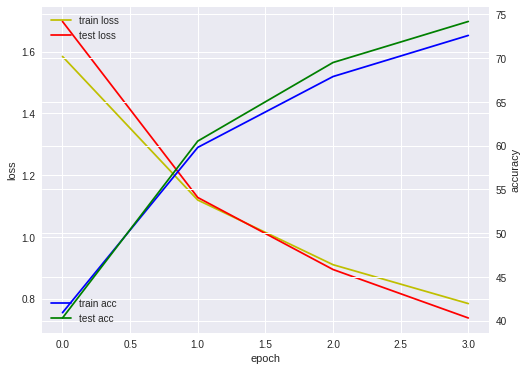

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots(figsize=(8,6))

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss_list, 'y', label='train loss')
loss_ax.plot(test_loss_list, 'r', label='test loss')

acc_ax.plot(train_acc_list, 'b', label='train acc')
acc_ax.plot(test_acc_list, 'g', label='test acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()